In [1]:
# Key Concepts
'''
1. Forward problem: θ → x (simulation)
2. Inverse problem: x → θ (what we're solving)
3. Posterior: P(θ|x) probability distribution over parameters
4. Prior: Initial assumptions about parameter ranges
'''
import pandas as pd
import numpy as np
import sys

# seaparate into train and test set.
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
#from torch.distributions import Uniform, ExpTransform, TransformedDistribution #, AffineTransform
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import os 
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage#, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_1P import plot_uvlf, plot_colour
from setup_params_SB import *
from priors_SB import initialise_priors_SB28

from variables_config_28 import uvlf_limits, n_bins_lf, colour_limits, n_bins_colour
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
bands = "all" # or just GALEX?

# lets try UVLF and colours this time.
colours = False  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

# initialize CAMELS and load parameter info using camels.py
cam = camels(model=model, sim_set='SB28')

if colours and not luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_only/"
    
elif luminosity_functions and not colours:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/"

elif colours and luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_lfs/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_lfs/"

# You might want to add an else for safety:
else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)


/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saving model in  /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/
Saving plots in  /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/


In [2]:
# parameter info file (df_info) is used for defining priors
# the actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)


# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)



          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

In [3]:
theta = df_pars.iloc[:, 1:29].to_numpy()  # excluding 'name' column and 'seed' column

print(theta)
print(theta.shape)

[[3.52541e-01 6.94742e-01 3.85743e+00 ... 2.25386e-01 2.69356e-04
  5.14648e-01]
 [1.72430e-01 8.30154e-01 1.03554e+00 ... 8.62311e-02 2.28022e-02
  2.62078e+00]
 [2.34683e-01 7.05844e-01 9.61416e+00 ... 6.48096e-01 1.45761e-03
  3.38956e+00]
 ...
 [2.34475e-01 9.38760e-01 1.49723e+00 ... 6.82619e-01 6.26319e-03
  3.11721e+00]
 [1.72613e-01 6.12888e-01 1.33125e+01 ... 8.36555e-02 7.09853e-05
  2.88794e+00]
 [3.52358e-01 8.62216e-01 3.09935e+00 ... 2.56220e-01 3.64932e-02
  9.94068e-01]]
(2048, 28)


In [4]:
print("Column names:")
print(df_pars.columns.tolist())

Column names:
['#Name', 'Omega0', 'sigma8', 'WindEnergyIn1e51erg', 'RadioFeedbackFactor', 'VariableWindVelFactor', 'RadioFeedbackReiorientationFactor', 'OmegaBaryon', 'HubbleParam', 'n_s', 'MaxSfrTimescale', 'FactorForSofterEQS', 'IMFslope', 'SNII_MinMass_Msun', 'ThermalWindFraction', 'VariableWindSpecMomentum', 'WindFreeTravelDensFac', 'MinWindVel', 'WindEnergyReductionFactor', 'WindEnergyReductionMetallicity', 'WindEnergyReductionExponent', 'WindDumpFactor', 'SeedBlackHoleMass', 'BlackHoleAccretionFactor', 'BlackHoleEddingtonFactor', 'BlackHoleFeedbackFactor', 'BlackHoleRadiativeEfficiency', 'QuasarThreshold', 'QuasarThresholdPower', 'seed']


(array([676., 348., 235., 178., 143., 121., 102.,  92.,  80.,  73.]),
 array([0.0250079 , 0.06248791, 0.09996792, 0.13744793, 0.17492794,
        0.21240795, 0.24988796, 0.28736797, 0.32484798, 0.36232799,
        0.399808  ]),
 <BarContainer object of 10 artists>)

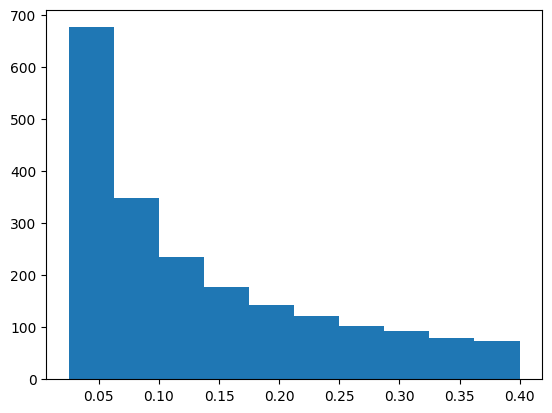

In [5]:
# plot the first one (omega0) to see shape of prior:
plt.hist(theta[:, 24])

In [6]:
if __name__ == "__main__":
    theta, x = get_theta_x_SB()
    print(theta.shape, x.shape)

torch.Size([2048, 28]) (2048, 36)


In [7]:
if colours:
    fig = plot_colour(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.show()

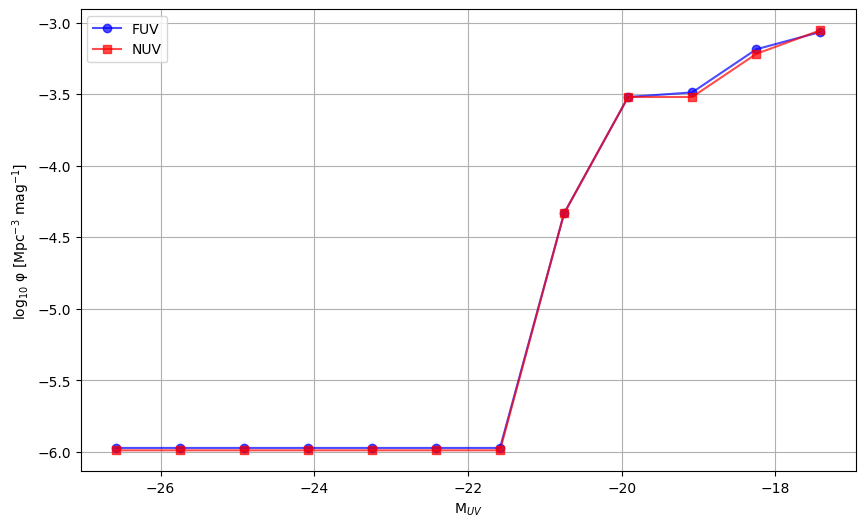

In [8]:
if luminosity_functions:
    fig = plot_uvlf(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()

In [9]:

# get the priors and data
prior = initialise_priors_SB28(
    df=df_info, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)

# process the data
x_all = np.array([np.hstack(_x) for _x in x])
x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

print("Theta shape:", theta.shape)
print("X shape:", x_all.shape)

processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:
processing OmegaBaryon:
processing OmegaBaryon is linear with min 0.029 and max 0.069:
processing HubbleParam:
processing HubbleParam is linear with min 0.4711 and max 0.8711:
processing n_s:
processing n_s is linear with min 0.7624 and max 1.1624:
processing MaxSfrTimescale:
processing MaxSfrTimescale is logarithmic with min 1.135 and max 4.54:
processing FactorForSofterEQS:
processing FactorForSo

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 28 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


In [10]:

# Move data to GPU as early as possible
x_all = x_all.to(device)
x_all


tensor([[-5.9718e+00, -5.9718e+00, -5.9718e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.9881e+00, -5.9881e+00, -5.9881e+00,  ...,  6.9378e-02,
          3.5885e-02,  2.6316e-02],
        [-5.9762e+00, -5.9762e+00, -5.9762e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-5.9622e+00, -5.9622e+00, -5.9622e+00,  ...,  1.6349e-02,
          8.1744e-03,  0.0000e+00],
        [-5.9627e+00, -5.9627e+00, -5.9627e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.9961e+00, -5.9961e+00, -5.9961e+00,  ...,  2.5126e-02,
          2.0101e-02,  5.0251e-03]], device='cuda:0')

In [11]:
theta = torch.tensor(theta, dtype=torch.float32, device=device)
theta

/tmp/ipykernel_4159290/964306182.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32, device=device)


tensor([[3.5254e-01, 6.9474e-01, 3.8574e+00,  ..., 2.2539e-01, 2.6936e-04,
         5.1465e-01],
        [1.7243e-01, 8.3015e-01, 1.0355e+00,  ..., 8.6231e-02, 2.2802e-02,
         2.6208e+00],
        [2.3468e-01, 7.0584e-01, 9.6142e+00,  ..., 6.4810e-01, 1.4576e-03,
         3.3896e+00],
        ...,
        [2.3448e-01, 9.3876e-01, 1.4972e+00,  ..., 6.8262e-01, 6.2632e-03,
         3.1172e+00],
        [1.7261e-01, 6.1289e-01, 1.3312e+01,  ..., 8.3655e-02, 7.0985e-05,
         2.8879e+00],
        [3.5236e-01, 8.6222e-01, 3.0993e+00,  ..., 2.5622e-01, 3.6493e-02,
         9.9407e-01]], device='cuda:0')

In [12]:
# Handle NaN values and normalize while on GPU
x_all_cpu = x_all.cpu().numpy()  # Only move to CPU when necessary for sklearn
x_all_cpu


array([[-5.9717813e+00, -5.9717813e+00, -5.9717813e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.9881158e+00, -5.9881158e+00, -5.9881158e+00, ...,
         6.9377989e-02,  3.5885166e-02,  2.6315790e-02],
       [-5.9762177e+00, -5.9762177e+00, -5.9762177e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-5.9622416e+00, -5.9622416e+00, -5.9622416e+00, ...,
         1.6348774e-02,  8.1743868e-03,  0.0000000e+00],
       [-5.9626508e+00, -5.9626508e+00, -5.9626508e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.9960556e+00, -5.9960556e+00, -5.9960556e+00, ...,
         2.5125628e-02,  2.0100502e-02,  5.0251256e-03]], dtype=float32)

In [13]:
print("Data shape before processing:", x_all_cpu.shape)
print("Number of values:",(x_all_cpu).sum())
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())

# how many nan values are there? if they are all nan something has gone horribly wrong.
# this looks better - 18th Nov

Data shape before processing: (2048, 36)
Number of values: -225130.23
Number of NaN values: 0
Number of infinite values: 0


In [14]:

# get rid of NaN/inf values, replace with small random noise
nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
nan_mask



array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:

if nan_mask.any():
    x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10


In [16]:
x_all_cpu

array([[-5.9717813e+00, -5.9717813e+00, -5.9717813e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.9881158e+00, -5.9881158e+00, -5.9881158e+00, ...,
         6.9377989e-02,  3.5885166e-02,  2.6315790e-02],
       [-5.9762177e+00, -5.9762177e+00, -5.9762177e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-5.9622416e+00, -5.9622416e+00, -5.9622416e+00, ...,
         1.6348774e-02,  8.1743868e-03,  0.0000000e+00],
       [-5.9626508e+00, -5.9626508e+00, -5.9626508e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.9960556e+00, -5.9960556e+00, -5.9960556e+00, ...,
         2.5125628e-02,  2.0100502e-02,  5.0251256e-03]], dtype=float32)

In [17]:
print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


Data shape before processing: (2048, 36)
Number of NaN values: 0
Number of infinite values: 0


In [18]:

# Normalize
'''
With normalization:
- All values brought to similar scale
- Neural network can learn more effectively
- No single bin dominates the learning
'''

norm = Normalizer()

# Option: Add small constant before normalizing
epsilon = 1e-10  # Small constant
x_all_shifted = x_all_cpu + epsilon
x_all_normalized = norm.fit_transform(x_all_shifted)
x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)

'''
x_all_normalized = norm.fit_transform(x_all_cpu)
x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)
'''
x_all

tensor([[-2.3794e-01, -2.3794e-01, -2.3794e-01,  ...,  3.9845e-12,
          3.9845e-12,  3.9845e-12],
        [-2.4248e-01, -2.4248e-01, -2.4248e-01,  ...,  2.8094e-03,
          1.4531e-03,  1.0656e-03],
        [-2.5381e-01, -2.5381e-01, -2.5381e-01,  ...,  4.2469e-12,
          4.2469e-12,  4.2469e-12],
        ...,
        [-2.4442e-01, -2.4442e-01, -2.4442e-01,  ...,  6.7022e-04,
          3.3511e-04,  4.0995e-12],
        [-2.1867e-01, -2.1867e-01, -2.1867e-01,  ...,  3.6673e-12,
          3.6673e-12,  3.6673e-12],
        [-2.3707e-01, -2.3707e-01, -2.3707e-01,  ...,  9.9339e-04,
          7.9472e-04,  1.9868e-04]], device='cuda:0')

In [19]:
# Add some diagnostics for the normalized data
def analyze_normalization(x_all):
    """Analyze the normalized data distribution"""
    x_numpy = x_all.cpu().numpy()
    
    print("Normalization Statistics:")
    print(f"Mean: {np.mean(x_numpy):.6f}")
    print(f"Std: {np.std(x_numpy):.6f}")
    print(f"Min: {np.min(x_numpy):.6f}")
    print(f"Max: {np.max(x_numpy):.6f}")
    print(f"Zero elements: {np.sum(x_numpy == 0)} out of {x_numpy.size}")
    
    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.hist(x_numpy.flatten(), bins=50, density=True)
    plt.title('Distribution of Normalized Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(plots_out_dir, 'normalization_distribution.png'))
    plt.close()

analyze_normalization(x_all)

# zero elements might refer to:
# empty magnitude bins (no galaxies in that magnitude range)
# below detection limit regions
# is actually normal for UVLFs

Normalization Statistics:
Mean: -0.126946
Std: 0.107993
Min: -0.326723
Max: 0.131679
Zero elements: 0 out of 73728


In [20]:

# Save normalizer
joblib.dump(norm, f'/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/{name}_scaler.save')

# Print final check
print("Any NaN in normalized data:", torch.isnan(x_all).any().item())
print("Any inf in normalized data:", torch.isinf(x_all).any().item())


Any NaN in normalized data: False
Any inf in normalized data: False


In [21]:

# make test mask
test_mask = create_test_mask() # 10% testing
test_mask


Total simulations: 2048
Test set size: 203
Training set size: 1845
Test fraction: 0.099


array([False,  True, False, ..., False, False, False])

In [22]:
train_mask = ~test_mask # 90% for training
train_mask


array([ True, False,  True, ...,  True,  True,  True])

In [23]:
# NPE: train a neural network to learn the mapping between the observed data and the posterior distribution of the parameters
# Use simulation-based approaches (like the CAMELS simulations you mentioned) to generate many realizations of the observed data and the corresponding model parameters.
# Train a neural network to take the observed data as input and output the parameters of the posterior distribution (e.g. mean, variance) for those parameters.
# Once the neural network is trained, you can apply it to the actual observed data to obtain estimates of the posterior distributions of the model parameters.

# Training arguments
train_args = {
    "training_batch_size": 32, # changed from 4 to 10 as dealing with more sims, want it to be faster for initial testing.
    "learning_rate": 1e-4,
    "stop_after_epochs": 50, # loss function. waits to see if things improve.
    "validation_fraction": 0.1,  # creates another split within the training data for validation
}

# Configure network
hidden_features = 20 #neurons
num_transforms = 1 #layers


nets = [ili.utils.load_nde_sbi(
    engine="NPE",
    model="nsf",
    hidden_features=hidden_features,
    num_transforms=num_transforms
)]

# do ensemble when optimsed first Network
'''
nets = [
    ili.utils.load_nde_sbi(
        engine="NPE",# Neural Posterior Estimation
        model="nsf",# Neural Spline Flow
        hidden_features=hidden_features,# Network width
        num_transforms=num_transforms# Network depth
    ) for _ in range(3) # for n NNs
]
'''

# Data loader
loader = NumpyLoader(

    # x = x_all[train_mask]
    # theta=theta[train_mask]
    # clone - makes new memory allocation for this version of x/theta
    # detach - doesnt affect computations on theta that were done previously (not to mess with test/train versions)
    x=x_all[train_mask].clone().detach(),
    theta=theta[train_mask].clone().detach()
)


# Runner setup with device specified here
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets= nets,
    device=device,  # Device specified in runner, not network
    train_args=train_args,
    proposal=None,
    out_dir=model_out_dir,
    name=name
)

# Run training - 'learn the likelihood'
# this is training the neural network which will act like our likelihood!
posterior_ensemble, summaries = runner(loader=loader)

# process of training:
'''
- the neural network learns P(θ|x): probability of parameters given observations
- uses training data to learn mapping from x → θ
- then we validate on held-out portion of training data
'''


INFO:root:MODEL INFERENCE CLASS: NPE
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 1.


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
posterior_ensemble

In [ ]:
summaries

In [ ]:
print("training_batch_size", train_args[ "training_batch_size"])
print("learning_rate", train_args[ "learning_rate"])
print("stop_after_epochs", train_args[ "stop_after_epochs"])
print("validation_fraction", train_args[ "validation_fraction"])
print("hidden_features", hidden_features)
print("num_transforms", num_transforms)


In [ ]:
def plot_training_diagnostics(summaries):
    """Plot training diagnostics without empty subplots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Changed to 1 row, 2 columns
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Use the function
fig = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(plots_out_dir, f'training_analysis_{name}.png'))
plt.show()
plt.close()

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# will this work or do we have to use it explicitly?
x_train=x_all[train_mask].clone().detach(),
theta_train=theta[train_mask].clone().detach()


In [ ]:
len(x_train[0])


In [ ]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# 1. prints our info on model configuration and architecture
print(posterior_ensemble.signatures)


# 2. choose a random input for training
seed_in = 49
np.random.seed(seed_in) # set seed for reproducability
ind = np.random.randint(len(x_train[0])) # choose observation (random index from training data)

# 3. generate posterior samples
seed_samp = 32
torch.manual_seed(seed_samp)# set seed for reproducability
# then, for the chosen training sample (as chosen above in 2.)
# generate 1000 samples from the posterior distribution using accept/reject sampling
samples = posterior_ensemble.sample(
    (1000,), 
    torch.Tensor(x_train[0][ind]).to(device))

# 4. calculate the probability densities for each sample
# i.e for each generated sample, calculate how likely it is using learned posterior distribution
log_prob = posterior_ensemble.log_prob(
    samples, # the generated samples from 3.
    torch.Tensor(x_train[0][ind]).to(device) # the chosen observation from 2.
    )

# convert to numpy so can read easier.
samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

In [ ]:
from matplotlib.gridspec import GridSpec
def plot_posterior_samples_grid(samples, log_prob, param_names, df_info, model_name, train_args):
   n_params = len(param_names)
   n_cols = 4
   n_rows = (n_params + n_cols - 1) // n_cols
   
   fig = plt.figure(figsize=(20, 5*n_rows))
   
   # Add main title
   fig.suptitle('Posterior Probability Distributions', fontsize=16, y=0.98)
   
   gs = GridSpec(n_rows, n_cols, figure=fig)
   
   # Model info text
   model_info = (
       f"Model Config:\n"
       f"Name: {model_name}\n"
       f"Hidden Features: {hidden_features}\n"
       f"Num Transforms: {num_transforms}\n"
       f"\nTraining Args:\n"
       f"Batch Size: {train_args['training_batch_size']}\n"
       f"Learning Rate: {train_args['learning_rate']}\n"
       f"Stop After Epochs: {train_args['stop_after_epochs']}"
   )
   
   fig.text(0.02, 0.96, model_info, 
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
            verticalalignment='top')
   
   for i, name in enumerate(param_names):
       row = i // n_cols
       col = i % n_cols
       
       ax = fig.add_subplot(gs[row, col])
       data = samples[:, i]
       param_info = df_info[df_info['ParamName'] == name].iloc[0]
       is_log = param_info['LogFlag'] == 1
       
       if is_log:
           ax.hist(data, bins=50, density=True, alpha=0.6)
           ax.set_xscale('log')
           log_data = np.log10(data)
           mean = np.mean(log_data)
           std = np.std(log_data)
           stats_text = f'Log10 Mean: {mean:.3f}\nLog10 Std: {std:.3f}'
           ax.set_xlabel('Parameter Value (log scale)', fontsize=8)
       else:
           ax.hist(data, bins=50, density=True, alpha=0.6)
           mean = np.mean(data)
           std = np.std(data)
           stats_text = f'Mean: {mean:.3f}\nStd: {std:.3f}'
           ax.set_xlabel('Parameter Value', fontsize=8)
       
       ax.set_ylabel('Density', fontsize=8)
       
       ax.axvline(param_info['MinVal'], color='g', linestyle=':', alpha=0.5, label='Min')
       ax.axvline(param_info['MaxVal'], color='g', linestyle=':', alpha=0.5, label='Max')
       ax.axvline(param_info['FiducialVal'], color='r', linestyle='--', alpha=0.5, label='Fiducial')
       
       ax.text(0.02, 0.95, stats_text, transform=ax.transAxes, 
               verticalalignment='top', fontsize=8, 
               bbox=dict(facecolor='white', alpha=0.8))
       
       ax.set_title(f"{name}\n{param_info['Description']}", fontsize=8, pad=5)
       ax.tick_params(labelsize=8)
       
       if i == 0:
           ax.legend(loc='upper right', fontsize=8)
   
   plt.tight_layout()
   plt.subplots_adjust(top=0.93)  # Adjusted to make room for main title
   return fig

# Get all parameter names from df_info
param_names = df_info['ParamName'].tolist()

# Now try plotting again with the correct parameter names
fig = plot_posterior_samples_grid(
    samples, 
    log_prob, 
    param_names,  # Now contains all 28 parameter names correctly
    df_info,
    model_name=name,
    train_args=train_args
)

# Save with model config in filename
save_name = (f'parameter_posteriors_grid_{name}_'
            f'h{hidden_features}_t{num_transforms}_'
            f'b{train_args["training_batch_size"]}_'
            f'e{train_args["stop_after_epochs"]}.png')

os.makedirs(plots_out_dir, exist_ok=True)
plt.savefig(os.path.join(plots_out_dir, save_name), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
log_prob

In [ ]:

# 6. Evaluation Metrics
'''
- Coverage: How often true parameters fall within predicted ranges:
-- perfect diagonal line means perfect coverage
-- points above diaganol means over-confident predictions
-- points below diagonal means under-confident
-- large deviations from the diaganol means poorly calibrated model

- Histogram:
-- uniform (straight) distributions of p-values means well-calibrated model
-- u-shaped dist: under-confident model
-- bell shaped: over confident model

- Predictions: Compare model predictions with observations
-- True values from your test set (these are your "observations")
-- Model's predicted distributions for each parameter
-- Predicted distributions centered on true values
-- Error bar estimates that accurately capture the true values
-- Scatter along diagonal: Good predictions
-- Systematic offset: Bias in predictions
-- Wide spread: High uncertainty
-- Clustering in certain regions: Model performs better for some parameter ranges
# The predictions are comparing:
# The true parameter values used in your simulations (like Omega0, sigma8, etc.) vs
# What your neural posterior estimation (NPE) model predicts these values should be
# based on the observables (your luminosity functions and/or colors)

- TARP: Total Absolute Relative Probability
-- lower values indicate better calibration
-- comparing across parameters can help identify which are harder to predict
-- high TARP values suggest need for model improvement for those parameters

'''

# to help with labelling to keep track of training args and improvements to model
# a configuration string for both filename and plot
config_str = (f"batch{train_args['training_batch_size']}_"
             f"lr{train_args['learning_rate']}_"
             f"epochs{train_args['stop_after_epochs']}_"
             f"h{hidden_features}_t{num_transforms}")

# coverage plots
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    out_dir=plots_out_dir,
)

# Generate plots
figs = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    theta=theta[test_mask, :].cpu(),
    signature=f"coverage_{name}_{config_str}_"  # Add config to filename
)

config_text = (
    f"Training Config:\n"
    f"Batch Size: {train_args['training_batch_size']}\n"
    f"Learning Rate: {train_args['learning_rate']}\n"
    f"Epochs: {train_args['stop_after_epochs']}\n"
    f"Hidden Features: {hidden_features}\n"
    f"Num Transforms: {num_transforms}"
)

# Process each figure
for i, fig in enumerate(figs):
    plt.figure(fig.number)  # Activate the figure
    plt.figtext(0.02, 0.98, config_text,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='top')
    
    # Save each figure with type indicator
    plot_types = ["coverage", "histogram", "predictions", "tarp"]
    plt.savefig(os.path.join(plots_out_dir, 
                f'metric_{plot_types[i]}_{name}_{config_str}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# First get the metrics as usual
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["predictions"],  # Only need predictions
    out_dir=plots_out_dir,
)

# Get the prediction data
figs = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    theta=theta[test_mask, :].cpu(),
    signature=f"predictions_{name}_"
)

# Now plot each parameter's predictions separately
def plot_individual_predictions(figs, cam_labels, config_text):
    """Plot true vs predicted values for each parameter separately"""
    
    for i, param_name in enumerate(cam_labels):
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Copy the prediction plot for this parameter from the original figure
        orig_ax = figs[0].axes[i]  # predictions are in first figure
        
        # Copy over the plot elements
        for line in orig_ax.get_lines():
            ax.plot(line.get_xdata(), line.get_ydata(), 
                   color=line.get_color(),
                   linestyle=line.get_linestyle(),
                   label=line.get_label())
            
        # Add labels and title
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title(f'Predictions for {param_name}')
        
        # Add config info
        ax.text(0.02, 0.98, config_text,
                transform=ax.transAxes,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='top')
        
        # Save individual plot
        plt.savefig(os.path.join(plots_out_dir, 
                    f'prediction_{param_name}_{name}.png'),
                    dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

# Create the plots
plot_individual_predictions(figs, cam.labels, config_text)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have:
# true_values: shape (n_samples, 28)
# predicted_means: shape (n_samples, 28)
# predicted_stds: shape (n_samples, 28)
# parameter_names: list of 28 parameter names

fig, axes = plt.subplots(4, 7, figsize=(24, 14))
axes = axes.flatten()

for i in range(28):
    ax = axes[i]
    
    # Plot error bars
    ax.errorbar(true_values[:, i], predicted_means[:, i],
               yerr=predicted_stds[:, i],
               fmt='k.', alpha=0.5, capsize=2)
    
    # Add diagonal line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5)
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((true_values[:, i] - predicted_means[:, i])**2))
    r2 = np.corrcoef(true_values[:, i], predicted_means[:, i])[0,1]**2
    
    # Add metrics box
    ax.text(0.05, 0.95, f'RMSE = {rmse:.2f}\nR² = {r2:.2f}',
            transform=ax.transAxes, bbox=dict(facecolor='white'))
    
    ax.set_title(parameter_names[i])
    ax.set_xlabel('True')
    ax.set_ylabel('Inferred')

plt.tight_layout()
plt.show()